In [21]:
import os 
import re
import numpy as np
import pandas as pd
from textblob import TextBlob

import importlib
import myutils;importlib.reload(myutils);

%matplotlib inline

In [2]:
comments = pd.read_csv("../data/clean_comments.txt",sep="|",index_col=0)
print(comments.shape)
comments.columns = ['raw']
comments[:3]

(165, 1)


,raw
1,Miu is like a walking personality complex and ...
2,Maki Harukawa. Nobody can convince me otherwise!
3,"Not only my favorite of this game, but now bet..."


In [11]:
# since I know their names, I'll just count it myself
names = ['maki','kokichi','rantaro','ryoma','gonta','kaito','kibo','himiko','kaede', 'shuichi','miu','tsumugi','korekiyo','kirumi','tenko','angie']
len(names)

16

In [22]:
comments['raw_norm'] = comments['raw'].map(myutils.normalize_names)
comments['word_list'] = comments['raw_norm'].map(lambda x: re.split('[^a-z]',x))
comments[:3]

,raw,raw_norm,word_list,maki,kokichi,rantaro,ryoma,gonta,kaito,kibo,himiko,kaede,shuichi,miu,tsumugi,korekiyo,kirumi,tenko,angie
1,Miu is like a walking personality complex and ...,miu is like a walking personality complex and ...,"[miu, is, like, a, walking, personality, compl...",0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,Maki Harukawa. Nobody can convince me otherwise!,maki. nobody can convince me otherwise!,"[maki, , nobody, can, convince, me, otherwise, ]",1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,"Not only my favorite of this game, but now bet...","not only my favorite of this game, but now bet...","[not, only, my, favorite, of, this, game, , bu...",0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [13]:
for name in names:
    comments[name] = comments['word_list'].map(lambda x: int(name in x))

In [14]:
ranking = comments[names].sum().sort_values(ascending=False)
ranking

kokichi     54
kirumi      33
kaito       26
kibo        24
gonta       24
maki        23
angie       21
shuichi     20
himiko      20
tenko       17
miu         17
ryoma       15
rantaro     14
korekiyo    12
kaede       10
tsumugi      8
dtype: int64

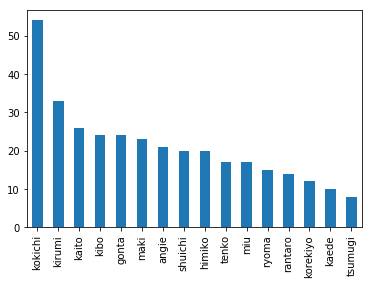

In [15]:
ranking.plot(kind='bar') 

### Dub! This bar plot is lame. Spice it up with their avartars!

In [24]:
import matplotlib.pyplot as plt
import PIL
from PIL import Image

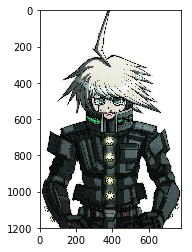

In [9]:
img = Image.open("../images/kibo.png")
plt.imshow(img)

In [10]:
def resize_keep_ratio(pic_path, desired_width):
    img = Image.open(pic_path)
    
    # Keep the ratio
    ratio = img.size[1]/img.size[0]
    desired_height = int(desired_width * ratio)
    
    # Resize
    thumbnail = img.resize((desired_width, desired_height), Image.ANTIALIAS)
    
    # Change to numpy array
    # figimage takes only float array in range 0-1 instead of 0-255
    img_array = np.array(thumbnail).astype(float) / 255
    return thumbnail

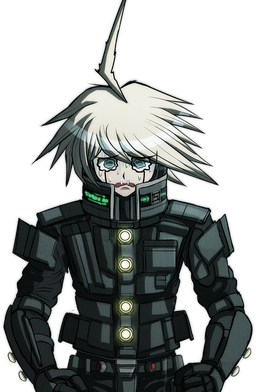

In [11]:
resize_keep_ratio("../images/kibo.png",256)

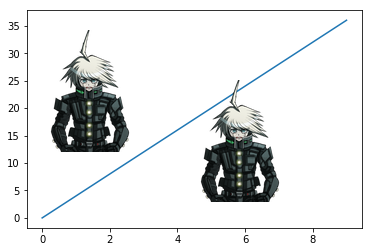

In [12]:
# Let's just put some crying kibos at some random spots...
img = np.array(resize_keep_ratio("../images/kibo.png",80))
fig = plt.figure()
plt.plot(np.arange(10), 4 * np.arange(10))
fig.figimage(img, 50, 100,zorder=1)
fig.figimage(img, 200, 50, zorder=1)

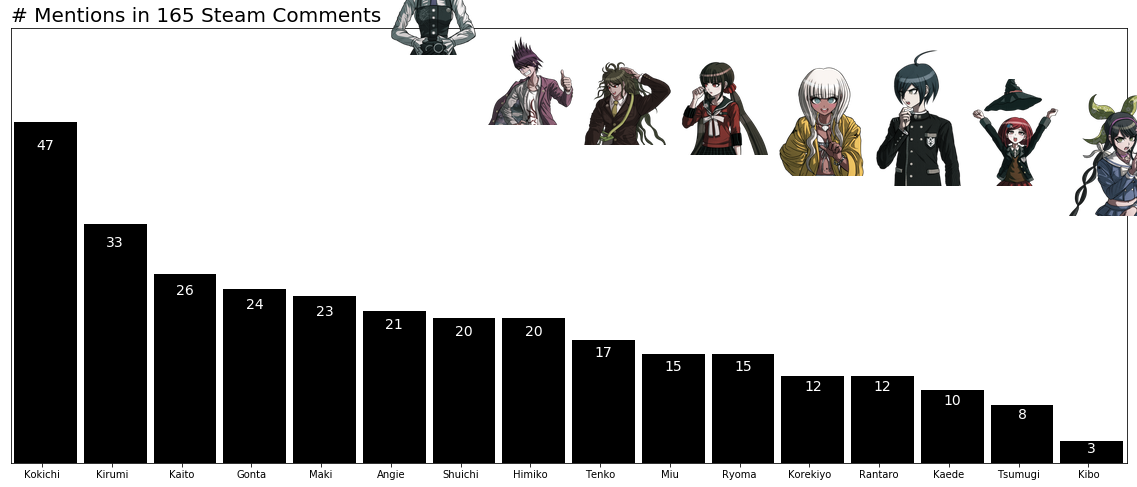

In [13]:
bar_widths = 0.9
ind = np.arange(len(ranking))
ticks = ind+bar_widths/2
names = list(ranking.index)

fig, ax = plt.subplots(figsize=(20,8))

rects = ax.bar(ind+0.5,ranking.values,bar_widths,color='black')

ax.set_xlim([-0,16])
ax.set_xticks(ticks)
ax.set_xticklabels([name.title() for name in names])

ax.set_ylim([0,60])
ax.set_yticks([])

# change bar width from coordinate system to display system
img_size = ax.transData.transform((bar_widths,0)) - ax.transData.transform((0,0)) 

# Read in images here since we now know the target size of resizing
imgs = {}
for root,_,files in os.walk("../images/"):
    for img in files:
        img_name = re.sub("\.png","",img)
        img_path = os.path.join(root,img)
        imgs[img_name] = resize_keep_ratio(img_path,int(img_size[0]))   
        
# Add images on above the bar
for i,img in enumerate(imgs):
    loc = ax.transData.transform((ticks[i],ranking.values[i]))
    fig.figimage(imgs[names[i]], loc[0], loc[1], zorder=1)

# Add number of mentions on the bar
for i,rect in enumerate(rects):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2., 0.95 * height, ranking.values[i],color='white',ha='center',size=14, va='top')

    
plt.title("# Mentions in 165 Steam Comments",size=20,loc='left')
    
plt.show()

### Whoops, what happens to my cute avartars??
There is note in matplotlib documentation that says GUI would mess up the coordinate transformation. The problem is not yet solved in for jupyter notebook

matplotlib coordinate transformation tutorial.
https://matplotlib.org/users/transforms_tutorial.html

Other people running into similar issue.
https://github.com/matplotlib/matplotlib/issues/4865/

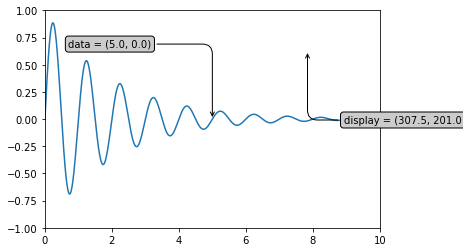

In [14]:
# Below is an example I pulled from the above matplotlib tutorial.
# Even this is messed up in jupyter
x = np.arange(0, 10, 0.005)
y = np.exp(-x/2.) * np.sin(2*np.pi*x)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(x, y)
ax.set_xlim(0, 10)
ax.set_ylim(-1, 1)

xdata, ydata = 5, 0
xdisplay, ydisplay = ax.transData.transform_point((xdata, ydata))

bbox = dict(boxstyle="round", fc="0.8")
arrowprops = dict(
    arrowstyle = "->",
    connectionstyle = "angle,angleA=0,angleB=90,rad=10")

offset = 72
ax.annotate('data = (%.1f, %.1f)'%(xdata, ydata),
            (xdata, ydata), xytext=(-2*offset, offset), textcoords='offset points',
            bbox=bbox, arrowprops=arrowprops)


disp = ax.annotate('display = (%.1f, %.1f)'%(xdisplay, ydisplay),
            (xdisplay, ydisplay), xytext=(0.5*offset, -offset),
            xycoords='figure pixels',
            textcoords='offset points',
            bbox=bbox, arrowprops=arrowprops)
plt.show()

### Solution:
Move the whole plotting part to a .py and compile from command line, and the problem is solved!
See below for the final output.

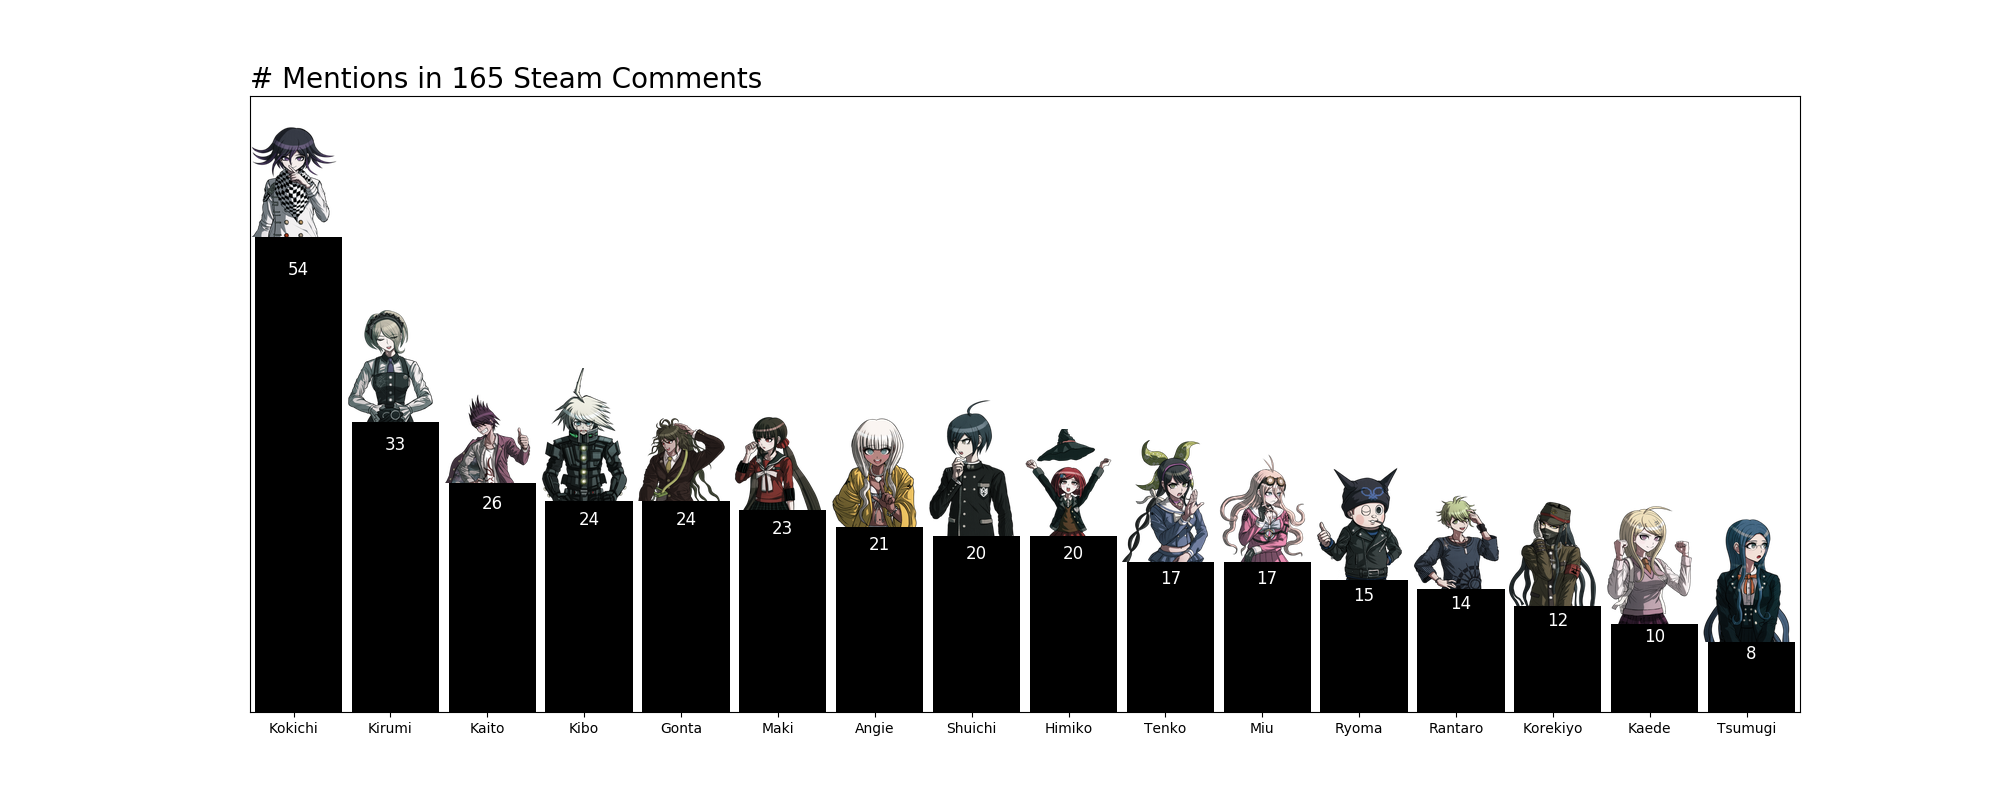

In [25]:
result = Image.open("../output/Mention.png")
result